## 1. 데이터 처리와 분류
---
- 라벨 데이터 처리하기
- sklearn의 rain_test_split함수를 이용하여 train, test 분리

### 데이터 불러오기

In [1]:
import numpy as np
import tensorflow as tf
import os

data_path = os.getenv("HOME") + '/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print('Wave data shape: ', speech_data['wav_vals'].shape)
print('Label data shape: ', speech_data['label_vals'].shape)

Wave data shape:  (50620, 8000)
Label data shape:  (50620, 1)


In [4]:
import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data['wav_vals']))
print('rand num: ', rand)

sr = 8000
data = speech_data['wav_vals'][rand]
print('Wave data shape: ', data.shape)
print('label: ', speech_data['label_vals'][rand])

ipd.Audio(data, rate=sr)

rand num:  37349
Wave data shape:  (8000,)
label:  ['stop']


### 2차원으로 변환

In [5]:
import librosa

data = speech_data['wav_vals']

def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
data_spec = []

for idx, wav in enumerate(data):
    if idx == 30000: break
    spec = wav2spec(wav)
    data_spec.append(spec)

data_spec = np.array(data_spec)

print(data_spec.shape)

(30000, 130, 126)


In [7]:
'''
from tqdm import tqdm

data_spec = []
for wav in tqdm(data):
    spec = wav2spec(wav)
    data_spec.append(spec)
    
data_spec = np.array(data_spec)'''

'\nfrom tqdm import tqdm\n\ndata_spec = []\nfor wav in tqdm(data):\n    spec = wav2spec(wav)\n    data_spec.append(spec)\n    \ndata_spec = np.array(data_spec)'

In [8]:
print(data_spec.shape)

(30000, 130, 126)


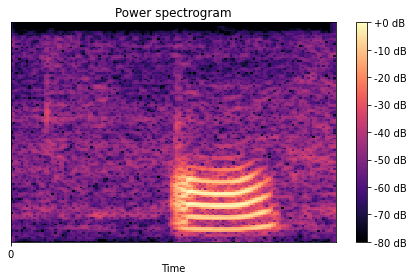

In [9]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### Train / Test 

In [10]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [11]:
temp = []
for v in speech_data['label_vals']:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

In [12]:
label_data=label_data[:30000]

In [13]:
label_data.shape

(30000,)

In [14]:
from sklearn.model_selection import train_test_split

train_spec, test_spec, train_label, test_label = train_test_split(
    data_spec, label_data, test_size=0.1, shuffle=True
)


In [15]:
print('train data: ', train_spec.shape)
print('train labels: ', train_label.shape)
print('test data: ', test_spec.shape)
print('test labels: ', test_label.shape)

train data:  (27000, 130, 126)
train labels:  (27000,)
test data:  (3000, 130, 126)
test labels:  (3000,)


## 2. 학습을 위한 하이퍼 파라미터 설정
---

In [16]:
batch_size = 16
max_epochs = 10

checkpoint_dir = os.getenv('HOME') + '/project/aiffel/e/e25/models/'

checkpoint_dir

'/home/aiffel0042/project/aiffel/e/e25/models'

## 3. 데이터셋 구성
---
- tf.data.Dataset 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플(data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리

In [17]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label

In [18]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
---
- 2차원 Spectogram 데이터의 시간축 방향으로 Conv1D layer 적용, 혹은 Conv2D layer 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험
    - 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력: loss, accuracy
    - Test dataset을 이용해서 모델의 성능 평가: 저장한 weight 불러오기, 모델의 예측값과 정답값이 얼마나 일치하는지 확인

### plain_conv1d 모델

In [24]:
from tensorflow.keras import layers


input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_plain_1d = tf.keras.Model(input_tensor, output_tensor)

model_plain_1d.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)           

In [25]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model_plain_1d.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      optimizer=optimizer,
                      metrics=['accuracy'])

### plain_conv2d 모델

In [19]:
from tensorflow.keras import layers


input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_plain_2d = tf.keras.Model(input_tensor, output_tensor)

model_plain_2d.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)       

In [20]:
# model_plain_2d = plain_2d_model((130, 126, 1))

In [21]:
model_plain_2d.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      optimizer=optimizer,
                      metrics=['accuracy'])

## 5. 모델 학습 

### plain_conv1d 모델

In [22]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [26]:
history_plain_1d = model_plain_1d.fit(train_dataset,
                                     epochs=max_epochs,
                                     steps_per_epoch=len(train_spec) // batch_size,
                                     validation_data=test_dataset,
                                     validation_steps=len(test_spec) // batch_size,
                                     callbacks=[cp_callback])

Epoch 1/10
1677/1687 [============================>.] - ETA: 0s - loss: 1.4332 - accuracy: 0.4978
Epoch 00001: val_loss did not improve from 0.09108
1687/1687 [==============================] - 8s 5ms/step - loss: 1.4300 - accuracy: 0.4991 - val_loss: 0.9038 - val_accuracy: 0.6872
Epoch 2/10
1676/1687 [============================>.] - ETA: 0s - loss: 0.7504 - accuracy: 0.7415
Epoch 00002: val_loss did not improve from 0.09108
1687/1687 [==============================] - 8s 5ms/step - loss: 0.7489 - accuracy: 0.7418 - val_loss: 0.5018 - val_accuracy: 0.8265
Epoch 3/10
1678/1687 [============================>.] - ETA: 0s - loss: 0.4889 - accuracy: 0.8365
Epoch 00003: val_loss did not improve from 0.09108
1687/1687 [==============================] - 8s 5ms/step - loss: 0.4882 - accuracy: 0.8368 - val_loss: 0.3802 - val_accuracy: 0.8646
Epoch 4/10
1682/1687 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8773
Epoch 00004: val_loss did not improve from 0.09108
1687/

### plain_conv2d 모델

In [23]:
history_plain_2d = model_plain_2d.fit(train_dataset,
                                     epochs=max_epochs,
                                     steps_per_epoch=len(train_spec) // batch_size,
                                     validation_data=test_dataset,
                                     validation_steps=len(test_spec) // batch_size,
                                     callbacks=[cp_callback])

Epoch 1/10
1687/1687 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.7407
Epoch 00001: val_loss improved from inf to 0.27976, saving model to /home/aiffel0042/project/aiffel/e/e25/models
1687/1687 [==============================] - 181s 107ms/step - loss: 0.7674 - accuracy: 0.7407 - val_loss: 0.2798 - val_accuracy: 0.9134
Epoch 2/10
1687/1687 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9208
Epoch 00002: val_loss improved from 0.27976 to 0.16800, saving model to /home/aiffel0042/project/aiffel/e/e25/models
1687/1687 [==============================] - 184s 109ms/step - loss: 0.2500 - accuracy: 0.9208 - val_loss: 0.1680 - val_accuracy: 0.9449
Epoch 3/10
1687/1687 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9437
Epoch 00003: val_loss did not improve from 0.16800
1687/1687 [==============================] - 183s 109ms/step - loss: 0.1717 - accuracy: 0.9437 - val_loss: 0.1827 - val_accuracy: 0.9405
Epoch 4/10
168

### 학습과정 시각화

Text(0.5, 1.0, 'Validation Accuracy')

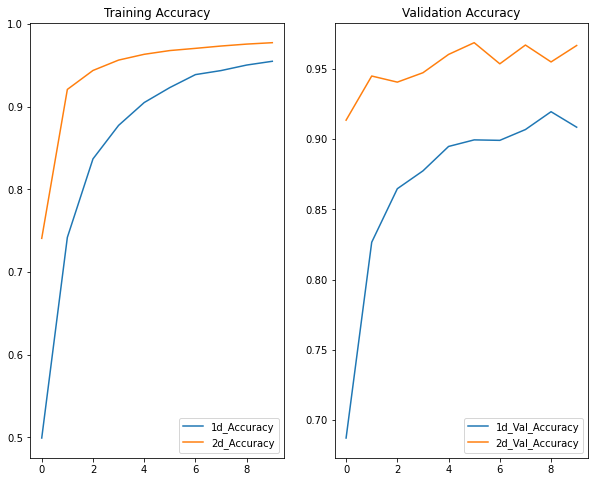

In [33]:
import matplotlib.pyplot as plt

plain_1d_acc = history_plain_1d.history['accuracy']
plain_1d_val_acc = history_plain_1d.history['val_accuracy']
plain_2d_acc = history_plain_2d.history['accuracy']
plain_2d_val_acc = history_plain_2d.history['val_accuracy']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(plain_1d_acc, label='1d_Accuracy')
plt.plot(plain_2d_acc, label='2d_Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(plain_1d_val_acc, label='1d_Val_Accuracy')
plt.plot(plain_2d_val_acc, label='2d_Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

Text(0.5, 1.0, 'Validation Loss')

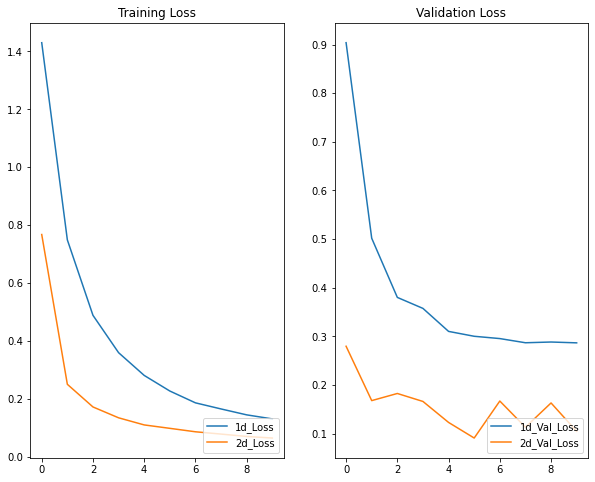

In [34]:
plain_1d_loss = history_plain_1d.history['loss']
plain_1d_val_loss = history_plain_1d.history['val_loss']
plain_2d_loss = history_plain_2d.history['loss']
plain_2d_val_loss = history_plain_2d.history['val_loss']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(plain_1d_loss, label='1d_Loss')
plt.plot(plain_2d_loss, label='2d_Loss')
plt.legend(loc='lower right')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(plain_1d_val_loss, label='1d_Val_Loss')
plt.plot(plain_2d_val_loss, label='2d_Val_Loss')
plt.legend(loc='lower right')
plt.title('Validation Loss')

2d 모델이 학습이 더 잘되는 것을 알 수 있다

## 6. 모델 평가

In [36]:
plain_1d_results = model_plain_1d.evaluate(test_dataset)

188/188 [==============================] - 5s 27ms/step - loss: 0.2868 - accuracy: 0.9087


In [66]:
plain_2d_results = model_plain_2d.evaluate(test_dataset)

188/188 [==============================] - 10s 54ms/step - loss: 0.1047 - accuracy: 0.9667


테스트시에도 Conv2D 모델의 성능이 훨씬 좋은 것을 확인할 수 있다.

In [65]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_plain_1d(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

sr = batch_xs.shape[1] * batch_xs.shape[2]
ipd.Audio(batch_xs.reshape(sr, ), rate=sr)

label :  left


In [53]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: go


- 테스트 데이터를 Spectogram으로 전환하기 전에 보존하지 않아서 음성으로 확인할 수 없었다.
- Spectogram 전환된 테스트데이터를 reshape해서 음성으로 출력한 결과 알수 없는 사운드만 들림
- Spectogram 전환된 테스트데이터를 다시 1차원 음성데이터로 전환할 수 있는지 추후 확인 필요

## 7. Skip-connection 모델 실험

In [69]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip], -1)
skip = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip], -1)
skip = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_skip = tf.keras.Model(input_tensor, output_tensor)

model_skip.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 130, 126, 32) 2624        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_21[0][0]                  
_______________________________________________________________________________________

In [70]:
model_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [71]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + 'model_skip',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [74]:
hisotry_skip = model_skip.fit(train_dataset, epochs=max_epochs, steps_per_epoch=len(train_spec) // batch_size,
                         validation_data=test_dataset, validation_steps=len(test_spec) // batch_size,
                         callbacks=[cp_callback])

Epoch 1/10
1687/1687 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.5988
Epoch 00001: val_loss improved from inf to 0.46610, saving model to /home/aiffel0042/project/aiffel/e/e25/modelsmodel_skip
1687/1687 [==============================] - 217s 129ms/step - loss: 1.1238 - accuracy: 0.5988 - val_loss: 0.4661 - val_accuracy: 0.8553
Epoch 2/10
1687/1687 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8907
Epoch 00002: val_loss improved from 0.46610 to 0.34304, saving model to /home/aiffel0042/project/aiffel/e/e25/modelsmodel_skip
1687/1687 [==============================] - 211s 125ms/step - loss: 0.3442 - accuracy: 0.8907 - val_loss: 0.3430 - val_accuracy: 0.8890
Epoch 3/10
1687/1687 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9295
Epoch 00003: val_loss improved from 0.34304 to 0.22040, saving model to /home/aiffel0042/project/aiffel/e/e25/modelsmodel_skip
1687/1687 [==============================] - 204s 121ms

Skip 모델은 Plain 모델에서 성능이 좋았던 conv2d로 구성하였으며, 평가 역시 plain_2d모델과 비교한다.

Text(0.5, 1.0, 'Validation Accuracy')

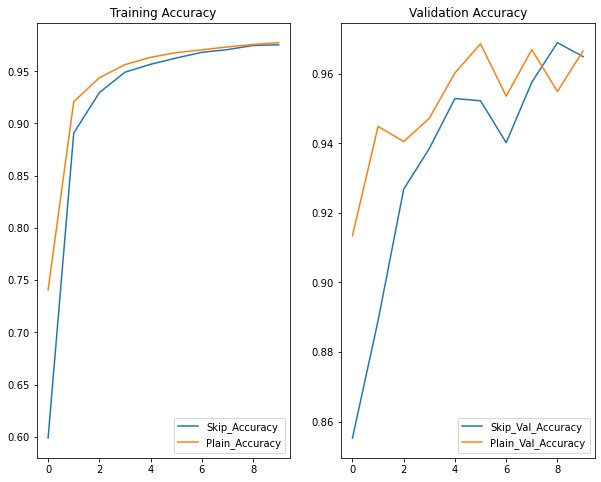

In [76]:
skip_2d_acc = hisotry_skip.history['accuracy']
skip_2d_val_acc = hisotry_skip.history['val_accuracy']
plain_2d_acc = history_plain_2d.history['accuracy']
plain_2d_val_acc = history_plain_2d.history['val_accuracy']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(skip_2d_acc, label='Skip_Accuracy')
plt.plot(plain_2d_acc, label='Plain_Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(skip_2d_val_acc, label='Skip_Val_Accuracy')
plt.plot(plain_2d_val_acc, label='Plain_Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

Text(0.5, 1.0, 'Validation Loss')

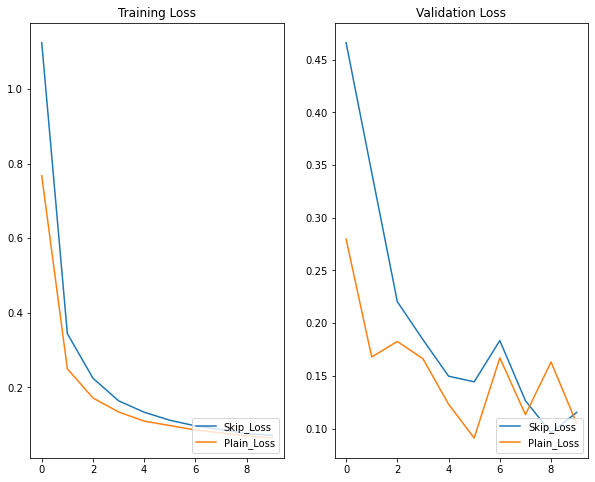

In [77]:
skip_2d_loss = hisotry_skip.history['loss']
skip_2d_val_loss = hisotry_skip.history['val_loss']
plain_2d_loss = history_plain_2d.history['loss']
plain_2d_val_loss = history_plain_2d.history['val_loss']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(skip_2d_loss, label='Skip_Loss')
plt.plot(plain_2d_loss, label='Plain_Loss')
plt.legend(loc='lower right')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(skip_2d_val_loss, label='Skip_Loss')
plt.plot(plain_2d_val_loss, label='Plain_Loss')
plt.legend(loc='lower right')
plt.title('Validation Loss')

학습 과정에서 Skip 모델과 Plain 모델 사이의 차이는 크지 않은 것 같다...

In [78]:
model_skip.load_weights(checkpoint_dir + 'model_skip')
result = model_skip.evaluate(test_dataset)

188/188 [==============================] - 7s 37ms/step - loss: 0.0960 - accuracy: 0.9690


테스트 시에 Plain_2d모델은 0.9667, Skip 모델은 0.9690으로 매우 미세하게 정확도가 향상(?)되었다 

In [80]:
test_spec.shape

(3000, 130, 126)

In [81]:
test_wav = []
for i, spec in enumerate(test_spec):
    reconstructed_spec = librosa.istft(spec)
    test_wav.append(reconstructed_spec)

In [ ]:
test_wav = np.array(test_wav)

test_wav.shape

In [90]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  right


In [91]:
sr = 8000
ipd.Audio(test_wav[batch_index], rate=8000)

In [92]:
print('예측: ', str(inv_label_value[np.argmax(y_pred_)]))

예측:  right


Spectogram 데이터를 성공적으로 wav로 변환해 모델의 예측을 확인해보는데 성공했다!

### Report
- Conv1D 와 Conv2D의 원리 상의 차이는 잘 알지 못했지만, 2차원 데이터에 Conv2D를 쓰는 것이 좋다는 것을 알 수 있었다.
- Skip 모델에서 딱히 성능의 향상이 없었는데 Skip 모델을 잘못 구성한 탓인지, Skip-Connection이 여기서는 딱히 효과가 없는 것인지 확인해볼 필요가 있겠다.